**Modelo SqueezeNet1_0**<br>
Link do Colab: https://colab.research.google.com/drive/1cEQN5s5xRX1QLW35_bIinTWHoIVr9m6-

In [ ]:
import kagglehub
from PIL import Image
import io
import random
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import os
import csv
import time

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Fixar o seed para reprodutividade
set_seed()

In [ ]:
# Download latest version
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

print("Path to dataset files:", path)

# Caminho para o dataset
train_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'

# Carrega o parquet
df = pd.read_parquet(train_path)

Path to dataset files: /kaggle/input/alzheimer-mri-disease-classification-dataset


In [ ]:
# Label map
label_map = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

In [ ]:
# Transforms padrão para ResNet
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # padrão ImageNet
                        std=[0.229, 0.224, 0.225])
])

In [ ]:
# Dataset customizado
class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_bytes = self.df.iloc[idx]['image']['bytes']
        label = self.df.iloc[idx]['label']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Criação do dataset e dataloader
dataset = AlzheimerDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Modelo com ResNet18 pré-treinada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo com AlexNet pré-treinada
model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)

# Substitui a camada final (classifier)
model.classifier[1] = torch.nn.Conv2d(512, 4, kernel_size=1)
model.num_classes = 4

model = model.to(device)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 71.0MB/s]


O SqueezeNet termina com <code>Conv2d</code> em vez de <code>Linear</code>, por isso o ajuste final é diferente do ResNet ou AlexNet.

Época 1/10: 100%|██████████| 320/320 [00:23<00:00, 13.37it/s]


Loss da época 1: 1.2588


Época 2/10: 100%|██████████| 320/320 [00:23<00:00, 13.43it/s]


Loss da época 2: 1.1179


Época 3/10: 100%|██████████| 320/320 [00:22<00:00, 14.19it/s]


Loss da época 3: 1.0291


Época 4/10: 100%|██████████| 320/320 [00:22<00:00, 14.28it/s]


Loss da época 4: 0.8887


Época 5/10: 100%|██████████| 320/320 [00:22<00:00, 14.37it/s]


Loss da época 5: 0.7163


Época 6/10: 100%|██████████| 320/320 [00:22<00:00, 14.34it/s]


Loss da época 6: 0.5834


Época 7/10: 100%|██████████| 320/320 [00:22<00:00, 14.31it/s]


Loss da época 7: 0.4972


Época 8/10: 100%|██████████| 320/320 [00:22<00:00, 14.11it/s]


Loss da época 8: 0.4065


Época 9/10: 100%|██████████| 320/320 [00:22<00:00, 14.53it/s]


Loss da época 9: 0.4254


Época 10/10: 100%|██████████| 320/320 [00:22<00:00, 14.43it/s]


Loss da época 10: 0.2973


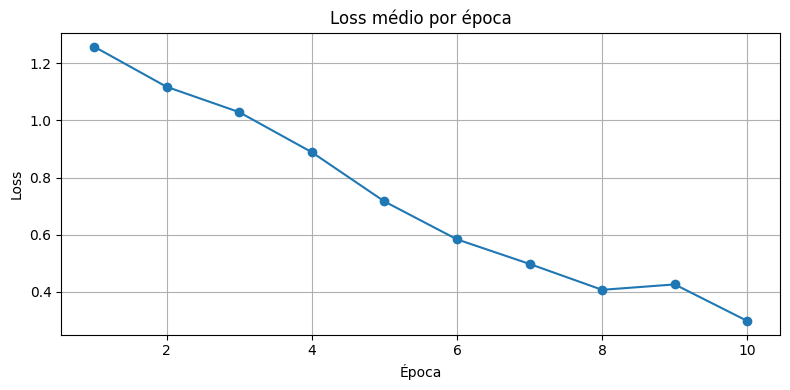

CPU times: user 3min 40s, sys: 1.3 s, total: 3min 42s
Wall time: 3min 46s


In [ ]:
%%time
# Número de exemplos por classe, na ordem dos rótulos
class_counts = torch.tensor([172, 15, 634, 459], dtype=torch.float32)

# Frequência relativa (dividido pelo total)
total = class_counts.sum()
freqs = class_counts / total

# Peso = inverso da frequência
weights = 1.0 / freqs

# Normaliza para evitar explosão de gradientes
weights = weights / weights.sum()

# Enviar para GPU
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm

# Inicializa histórico
epoch_losses = []
num_epochs = 10

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Loop por batch
    for images, labels in tqdm(dataloader, desc=f"Época {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Média da época
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Loss da época {epoch+1}: {epoch_loss:.4f}")

end_time = time.time()
tempo_total = end_time - start_time

# Grafico por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.title("Loss médio por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Caminho para o arquivo de teste
test_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'

# Lê o Parquet
df_test = pd.read_parquet(test_path)

# Cria o dataset e o dataloader de teste
test_dataset = AlzheimerDataset(df_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Coloque o modelo em modo de avaliação
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in tqdm(test_dataloader, desc="Avaliando"):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

Avaliando: 100%|██████████| 80/80 [00:04<00:00, 19.63it/s]


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

modelo = "SqueezeNet1_0"

# Relatório completo por classe
print(f"\nModelo {modelo}")
print("\nRelatório por classe:")
print(classification_report(y_true, y_pred, target_names=[label_map[i] for i in range(4)], zero_division=0))

Acurácia: 0.8055
Precisão: 0.8255
Revocação: 0.8055
F1-score: 0.7982

Modelo SqueezeNet1_0

Relatório por classe:
                    precision    recall  f1-score   support

     Mild_Demented       0.90      0.76      0.83       172
 Moderate_Demented       1.00      0.93      0.97        15
      Non_Demented       0.75      0.96      0.84       634
Very_Mild_Demented       0.89      0.60      0.72       459

          accuracy                           0.81      1280
         macro avg       0.89      0.81      0.84      1280
      weighted avg       0.83      0.81      0.80      1280



In [ ]:
# Calcula a matriz
cm = confusion_matrix(y_true, y_pred)

# Converte para DataFrame com rótulos
cm_df = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())

print("Matriz de confusão:\n")
print(cm_df.to_string())

Matriz de confusão:

                    Mild_Demented  Moderate_Demented  Non_Demented  Very_Mild_Demented
Mild_Demented                 131                  0            28                  13
Moderate_Demented               0                 14             0                   1
Non_Demented                    6                  0           609                  19
Very_Mild_Demented              8                  0           174                 277


In [ ]:
resultados = {
    "modelo": modelo,
    "epocas": num_epochs,
    "tempo_total": round(tempo_total, 2), # em segundos
    "acuracia": round(accuracy, 4),
    "precisao": round(precision, 4),
    "revocacao": round(recall, 4),
    "f1_macro": round(f1, 4)
}

In [ ]:
import re

def limpar_nome_arquivo(nome):
    """
    Substitui caracteres inválidos em nomes de arquivos por underline (_).

    Parâmetros:
    nome (str): O nome original do arquivo que pode conter caracteres inválidos.

    Retorna:
    str: Uma versão do nome do arquivo onde os caracteres inválidos (\, /, :, ", *, ?, <, >, |)
         foram substituídos por underscores (_), tornando o nome seguro para uso em sistemas de arquivos.
    """
    return re.sub(r'[\\/:"*?<>|]+', "_", nome)

nome_seguro = limpar_nome_arquivo(modelo)

In [ ]:
file_path = f"resultados_do_modelo_{nome_seguro}.csv"
campos = list(resultados.keys())

# Cria o arquivo se não existir
if not os.path.exists(file_path):
    with open(file_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writeheader()
        writer.writerow(resultados)
else:
    # Apenas adiciona nova linha
    with open(file_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writerow(resultados)